In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
stoi = {chr(i+96):i for i in range(1, 27)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}

In [4]:
block_size = 3

def build_dataset(words):
  X, Y = [], []


  for word in words:

    context = [0]*block_size

    for ch in word + '.':
      ix = stoi[ch]

      #print(''.join(itos[i] for i in context), '-->', ch)

      X.append(context)
      Y.append(ix)
      context = context[1:] +  [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)   # for reproducibility but words = [....] needs to run everytime
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xt, Yt = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [6]:
sum(p.nelement() for p in parameters)

3481

In [7]:
# mini batch
mb = torch.randint(0, Xtr.shape[0], (32,)) # random values from 0 to len(Xtr)(exclusive)
mb

tensor([157900,   4520,   8010, 170938,   3814, 169166, 158624, 132470,  89417,
        137855, 119949, 140561, 100671, 160260, 121008,  50544, 158155,   9832,
         11639, 132977,  33859,  43177, 123691,   5347, 125154, 156976, 111485,
        161009, 102046, 162641,  27942,  93035])

In [40]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20000):

  #mini batch
  ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

  # forward pass
  emb = C[Xtr[ix]]  # (32, 3, 2)   because Xtr[ix] is (32, 3)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # view will see emb as (32, 6) insead of (32, 3, 2)
  logits = h@W2 + b2
  # count = logits.exp()
  # prob = count/count.sum(1, keepdim=True)
  # loss = - prob[torch.arange(32), Ytr[ix]].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i<100000 else 0.01

  for p in parameters:
    p.data += -lr*p.grad

loss.data

tensor(1.8808)

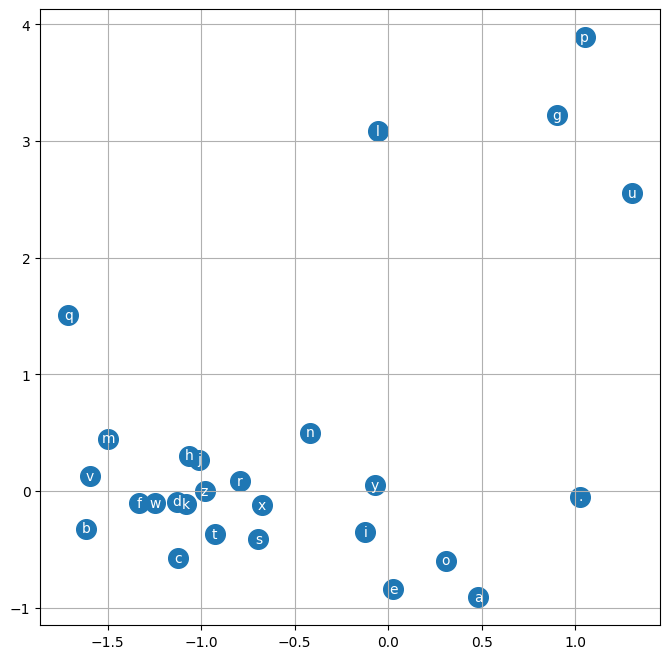

In [41]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [44]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3191, grad_fn=<NllLossBackward0>)

In [47]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayan.
seel.
nihah.
marethastendrari.
aderedielin.
shi.
jen.
emelisan.
aar.
kayziosttelin.
shubergiashiest.
jair.
jelinn.
terifous.
macdir.
yidulmers.
kay.
mistondrehia.
samylisus.
